In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class CVAE(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim, num_layers, initial_neurons):
        super(CVAE, self).__init__()
        # Adjust input dimension for augmented features (original + squared + cubed + exponential)
        augmented_dim = input_dim + condition_dim
        self.encoder = self.build_encoder(augmented_dim, num_layers, initial_neurons, latent_dim, condition_dim)
        self.decoder = self.build_decoder(latent_dim, condition_dim, num_layers, initial_neurons, input_dim)

    def build_encoder(self, input_dim, num_layers, initial_neurons, latent_dim, condition_dim):
        layers = []
        neurons = initial_neurons
        for i in range(num_layers):
            layers.append(nn.Linear(input_dim if i == 0 else neurons, neurons // 2))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(neurons // 2))
            layers.append(nn.Dropout(0.2))
            neurons //= 2
        layers.append(nn.Linear(neurons, latent_dim * 2))
        return nn.Sequential(*layers)

    def build_decoder(self, latent_dim, condition_dim, num_layers, initial_neurons, output_dim):
        layers = []
        neurons = initial_neurons // (2 ** num_layers)
        layers.append(nn.Linear(latent_dim + condition_dim, neurons))
        for i in range(num_layers):
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(neurons))
            layers.append(nn.Dropout(0.2))
            layers.append(nn.Linear(neurons, neurons * 2))
            neurons *= 2
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(neurons))
        layers.append(nn.Dropout(0.2))
        layers.append(nn.Linear(neurons, output_dim))
        return nn.Sequential(*layers)

    def encode(self, x, condition):
        x_cat = torch.cat([x, condition], dim=-1)
        h = self.encoder(x_cat)
        mean, log_var = torch.chunk(h, 2, dim=-1)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z, condition):
        z = torch.cat([z, condition], dim=-1)
        return self.decoder(z)

    def forward(self, x, condition):
        mean, log_var = self.encode(x, condition)
        z = self.reparameterize(mean, log_var)
        return self.decode(z, condition), mean, log_var

def loss_fn(recon_x, x, mean, log_var, beta=1):
    reconstruction_loss = nn.MSELoss()(recon_x, x)
    reconstruction_loss *= recon_x.shape[1]
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=-1)
    return reconstruction_loss + beta * kl_divergence.mean()

def loss_fn_charge(recon_x, x, mean, log_var, beta=1):
    charge = x[:, 0] * x[:, 1]
    recon_charge = recon_x[:, 0] * recon_x[:, 1]
    reconstruction_loss_charge = nn.MSELoss()(recon_charge, charge)
    reconstruction_loss_charge *= recon_charge.shape[0]

    reconstruction_loss_params = nn.MSELoss()(recon_x, x)
    reconstruction_loss_params *= recon_x.shape[0]

    reconstruction_loss = 0.5*reconstruction_loss_charge + 0.5*reconstruction_loss_params

    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=-1)
    return reconstruction_loss + beta * kl_divergence.mean()


def train_cvae(model, train_loader, val_loader, optimizer, epochs=100, device=DEVICE):
    model.to(device)
    best_loss = float('inf')
    beta = 1

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, condition in train_loader:
            x = x.to(device)
            condition = condition.to(device)

            optimizer.zero_grad()
            recon_x, mean, log_var = model(x, condition)
            loss = loss_fn(recon_x, x, mean, log_var, beta)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)

        train_loss /= len(train_loader.dataset)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for x, condition in val_loader:
                x = x.to(device)
                condition = condition.to(device)
                recon_x, mean, log_var = model(x, condition)
                loss = loss_fn(recon_x, x, mean, log_var, beta)
                val_loss += loss.item() * x.size(0)

        val_loss /= len(val_loader.dataset)
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_cvae_model.pth')
            print(f"Model saved at epoch {epoch + 1}")

In [3]:
# Load and transform the data
data = pd.read_csv('./drive/MyDrive/VagusNerveResearchProject/vns_dataset_threshold_type.csv')

# data = pd.get_dummies(data, columns=['fibre_type'])

data.loc[data['fibre_type'] == 'AB', 'fibre_type'] = 0.0
data.loc[data['fibre_type'] == 'C', 'fibre_type'] = 1.0

data = data.astype('float32')
data.head()

data_ab = data.loc[data['fibre_type'] == 0.0, :]
data_c = data.loc[data['fibre_type'] == 1.0, :]

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# One-Hot Encoding for Categorical Variable
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

X_cat = one_hot_encode(data[['fibre_type']].astype('int'), num_classes=2)
X_cat = X_cat.reshape(-1, 2)

X = data.loc[:, ['nerve_a', 'nerve_b', 'activation_level', 'frequency']]
X.loc[:, 'fibre_type_AB'] = X_cat[:, 0]
X.loc[:, 'fibre_type_C'] = X_cat[:, 1]

y = data.loc[:, ['pulse_width', 'amplitude']].values

X_ab = X[X['fibre_type_AB'] == 1.0]
X_c = X[X['fibre_type_C'] == 1.0]
y_ab = y[X['fibre_type_AB'] == 1.0]
y_c = y[X['fibre_type_C'] == 1.0]

# Normalize the continuous features
X_scaler_ab = StandardScaler()
X_ab_norm = X_scaler_ab.fit_transform(X_ab[['nerve_a', 'nerve_b', 'activation_level', 'frequency']])
X_scaler_c = StandardScaler()
X_c_norm = X_scaler_c.fit_transform(X_c[['nerve_a', 'nerve_b', 'activation_level', 'frequency']])

y_scaler_ab = StandardScaler()
y_ab_norm = y_scaler_ab.fit_transform(y_ab)
y_scaler_c = StandardScaler()
y_c_norm = y_scaler_c.fit_transform(y_c)

X_ab_norm = np.hstack([X_ab_norm, X_ab[['fibre_type_AB', 'fibre_type_C']].values])
X_c_norm = np.hstack([X_c_norm, X_c[['fibre_type_AB', 'fibre_type_C']].values])

X_norm = np.vstack([X_ab_norm, X_c_norm])
y_norm = np.vstack([y_ab_norm, y_c_norm])

inputs = torch.FloatTensor(y_norm)
conditions = torch.FloatTensor(X_norm)
# Split dataset into training and validation sets
dataset = TensorDataset(inputs, conditions)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [5]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.9 MB/s eta 0:00:00


In [6]:
import optuna

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

def objective(trial):
    input_dim = 2  # Replace with actual input dimension
    condition_dim = 6  # Replace with actual condition dimension

    # latent_dim = trial.suggest_int('latent_dim', 2, 32)
    # num_layers = trial.suggest_int('num_layers', 1, 4)
    # initial_neurons = trial.suggest_int('initial_neurons', 32, 512)
    # batch_size = trial.suggest_int('batch_size', 32, 128)

    latent_dim = 2
    num_layers = 3
    initial_neurons = 128
    batch_size = 128

    epochs = 50
    learning_rate = 0.001

    model = CVAE(input_dim, condition_dim, latent_dim, num_layers, initial_neurons)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_cvae(model, train_loader, val_loader, optimizer, epochs=epochs, device=DEVICE)

    model.load_state_dict(torch.load('best_cvae_model.pth'))

    val_loss = 0
    beta = 1
    model.eval()
    with torch.no_grad():
        for x, condition in val_loader:
            x = x.to(DEVICE)
            condition = condition.to(DEVICE)
            recon_x, mean, log_var = model(x, condition)
            loss = loss_fn(recon_x, x, mean, log_var, beta)
            val_loss += loss.item() * x.size(0)

    val_loss /= len(val_loader.dataset)
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-09-09 13:21:24,054] A new study created in memory with name: no-name-5f101696-bdc2-4198-8d6d-80f055cf5788


Epoch 1, Train Loss: 2.0099, Val Loss: 1.5403
Model saved at epoch 1
Epoch 2, Train Loss: 1.6048, Val Loss: 1.4099
Model saved at epoch 2
Epoch 3, Train Loss: 1.5115, Val Loss: 1.3963
Model saved at epoch 3
Epoch 4, Train Loss: 1.4957, Val Loss: 1.3365
Model saved at epoch 4
Epoch 5, Train Loss: 1.4549, Val Loss: 1.2801
Model saved at epoch 5
Epoch 6, Train Loss: 1.4575, Val Loss: 1.2752
Model saved at epoch 6
Epoch 7, Train Loss: 1.4459, Val Loss: 1.2803
Epoch 8, Train Loss: 1.4262, Val Loss: 1.3587
Epoch 9, Train Loss: 1.4277, Val Loss: 1.3271
Epoch 10, Train Loss: 1.4225, Val Loss: 1.3227
Epoch 11, Train Loss: 1.4174, Val Loss: 1.2872
Epoch 12, Train Loss: 1.4088, Val Loss: 1.2970
Epoch 13, Train Loss: 1.4066, Val Loss: 1.3185
Epoch 14, Train Loss: 1.4137, Val Loss: 1.3100
Epoch 15, Train Loss: 1.3880, Val Loss: 1.2778
Epoch 16, Train Loss: 1.4031, Val Loss: 1.2669
Model saved at epoch 16
Epoch 17, Train Loss: 1.4059, Val Loss: 1.2908
Epoch 18, Train Loss: 1.4103, Val Loss: 1.3319
E

<ipython-input-6-89dcf62f3985>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cvae_model.pth'))
[I 2024-09-09 13:26:31,690] Trial 0

Best trial:
  Value: 1.2556245229156693
  Params: 


In [7]:
# for each condition in conditions_norm, find the generated stimulation parameters
def generate_stimulation_parameters(cvae, condition, latent_dim, device='cpu'):
    cvae.eval()
    condition = torch.FloatTensor(condition).unsqueeze(0).to(device)
    with torch.no_grad():
        # Sample a random latent vector from standard normal distribution
        z = torch.randn(1, latent_dim).to(device)
        # z = torch.tensor([0.5, 0.5], dtype=torch.float32).to(device).unsqueeze(0)
        # Decode the latent vector along with the condition to generate input parameters
        stimulation_params = cvae.decode(z, condition)
    return stimulation_params

In [8]:
for i, c in val_dataset:
  print(i, c)
  break

tensor([ 1.9908, -0.9117]) tensor([ 0.0257,  0.7181, -0.6284, -0.8029,  1.0000,  0.0000])


<ipython-input-9-1ae3dd2f0292>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cvae.load_state_dict(torch.load('best_cvae_model.pth'))


(6482, 2)
(6482, 2)
(6482, 6)


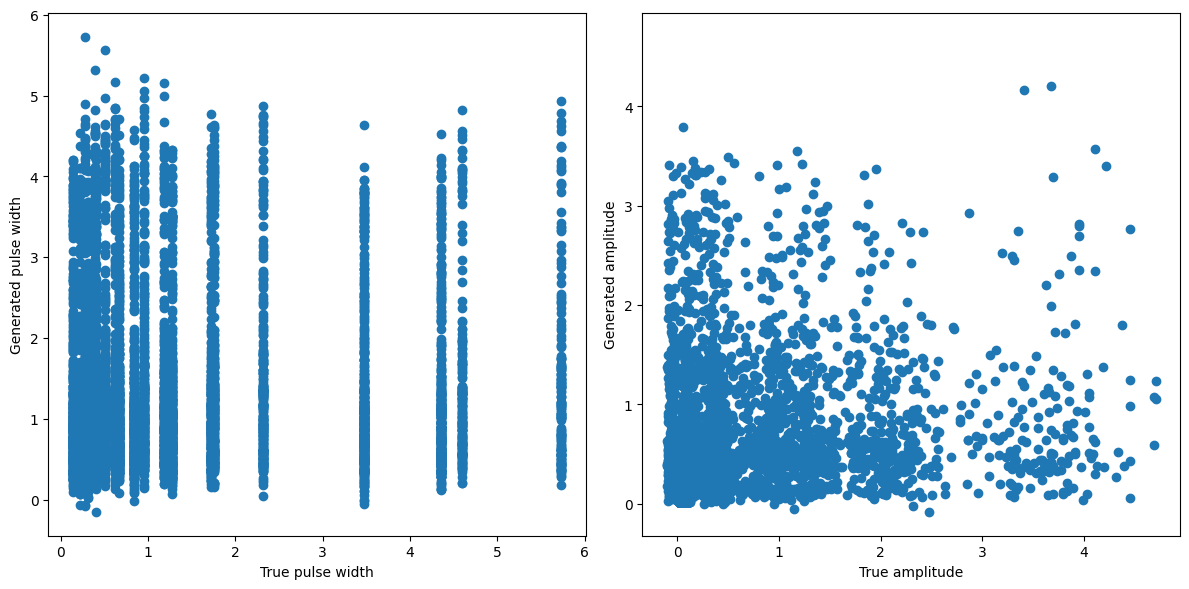

In [9]:
import matplotlib.pyplot as plt

cvae = CVAE(2, 6, 2, 3, 128)
cvae.load_state_dict(torch.load('best_cvae_model.pth'))
cvae.to(DEVICE)

latent_dim = 2

inputs_recon = []
val_inputs = []
val_conditions = []
for i, c in val_dataset:
    inputs_recon.append(generate_stimulation_parameters(cvae, c, latent_dim, device=DEVICE).cpu().detach().numpy())
    val_inputs.append(i.cpu().detach().numpy())
    val_conditions.append(c.cpu().detach().numpy())

inputs_recon = np.array(inputs_recon)
inputs_recon = inputs_recon.reshape(inputs_recon.shape[0], -1)
val_inputs = np.array(val_inputs)
val_conditions = np.array(val_conditions)

print(inputs_recon.shape)
print(val_inputs.shape)
print(val_conditions.shape)

inputs_recon_ab = inputs_recon[val_conditions[:, 4] == 0.0]
inputs_recon_c = inputs_recon[val_conditions[:, 4] == 1.0]
val_inputs_ab = val_inputs[val_conditions[:, 4] == 0.0]
val_inputs_c = val_inputs[val_conditions[:, 4] == 1.0]
val_conditions_ab = val_conditions[val_conditions[:, 4] == 0.0]
val_conditions_c = val_conditions[val_conditions[:, 4] == 1.0]

inputs_recon_ab = y_scaler_ab.inverse_transform(inputs_recon_ab)
inputs_recon_c = y_scaler_c.inverse_transform(inputs_recon_c)
val_inputs_ab[:, :4] = y_scaler_ab.inverse_transform(val_inputs_ab[:, :4])
val_inputs_c[:, :4] = y_scaler_c.inverse_transform(val_inputs_c[:, :4])
val_conditions_ab[:, :4] = X_scaler_ab.inverse_transform(val_conditions_ab[:, :4])
val_conditions_c[:, :4] = X_scaler_c.inverse_transform(val_conditions_c[:, :4])

inputs_recon = np.vstack([inputs_recon_ab, inputs_recon_c])
val_inputs = np.vstack([val_inputs_ab, val_inputs_c])
val_conditions = np.vstack([val_conditions_ab, val_conditions_c])

# plot them against x
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(val_inputs[:, 0], inputs_recon[:, 0])
ax[0].plot([min(val_inputs[:, 0]), min(val_inputs[:, 0])], [max(val_inputs[:, 0]), max(val_inputs[:, 0])], 'k--')
ax[0].set_xlabel('True pulse width')
ax[0].set_ylabel('Generated pulse width')

ax[1].scatter(val_inputs[:, 1], inputs_recon[:, 1])
ax[1].plot([min(val_inputs[:, 1]), min(val_inputs[:, 1])], [max(val_inputs[:, 1]), max(val_inputs[:, 1])], 'k--')
ax[1].set_xlabel('True amplitude')
ax[1].set_ylabel('Generated amplitude')

plt.tight_layout()
plt.show()


In [10]:
%pip install plotly

In [11]:
# get unique sample_id in data
sample_ids = data['nerve_a'].unique()
print(sample_ids)

[136.8129 194.339  292.6576 258.7481 272.9742 249.8817 308.9322 245.4187]


In [12]:
# 3D scatter plot of pulse width, amplitude and activation level
import plotly.graph_objs as go
import plotly.express as px

# data_c = data.loc[data['fibre_type'] == 1.0, :]
# data_ = data_c.loc[data_c['nerve_a'] == 194.339, :]

# Create the 3D scatter plot
fig = px.scatter_3d(
    data_frame=data,
    x='amplitude',
    y='pulse_width',
    z='activation_level',
    color='nerve_a',
    opacity=0.6,
    color_continuous_scale='Viridis'
)

# Update the layout
fig.update_layout(
    scene=dict(
        xaxis_title='Amplitude',
        yaxis_title='Pulse Width',
        zaxis_title='Activation Level'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Show the plot
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [17]:
# Create the 3D scatter plot
flt = (val_conditions[:, 4] == 1.0)

fig = px.scatter_3d(
    x=inputs_recon[flt, 1],
    y=inputs_recon[flt, 0],
    z=val_conditions[flt, 2],
    color=val_conditions[flt, 3],
    opacity=0.6,
    color_continuous_scale='Viridis'
)

# Update the layout
fig.update_layout(
    scene=dict(
        xaxis_title='Amplitude (mA)',
        yaxis_title='Pulse Width (ms)',
        zaxis_title='Activation Level'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.update_traces(marker=dict(size=7))

# Update legend text
fig.update_layout(
    coloraxis_colorbar=dict(title='Frequency (Hz)'),
)

# Show the plot
fig.show()